# Gaussian Process Regression

This notebook uses Gaussian Processes to infer velocity fields across entire images.

## Preparation

Load the microscopy images from a specific experiment's TIFF file as in our [data exploration](../piv/data_exploration.ipynb).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tifffile

from skimage import feature
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from scipy.optimize import least_squares
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment

# Local import
from piv.points_df import Points

In [2]:
experiment = '220530-E1_Out'

In [3]:
image_dir = 'data/tiff'
image_files = [f for f in os.listdir(image_dir) if experiment in f and f.endswith('.tiff')] # type: ignore
if len(image_files) > 1:
    raise ValueError(f'Expected only one image for experiment {experiment}, but found {len(image_files)}')

image = tifffile.TiffFile(f'{image_dir}/{image_files[0]}')
image_data = np.squeeze(image.asarray())

In [4]:
# Preparation for visual plotting
channel_red     = image_data[0] # shape -> (115, 512, 512)
channel_green   = image_data[1] # shape -> (115, 512, 512)

# Normalize for visualization 
channel_red_norm    = (channel_red - channel_red.min()) / (channel_red.max() - channel_red.min()) 
channel_green_norm  = (channel_green - channel_green.min()) / (channel_green.max() - channel_green.min())

# Create RG(B) stack for each slice
rgb_stack = np.zeros((115, 512, 512, 2), dtype=np.float32)
rgb_stack[..., 0] = channel_red_norm
rgb_stack[..., 1] = channel_green_norm

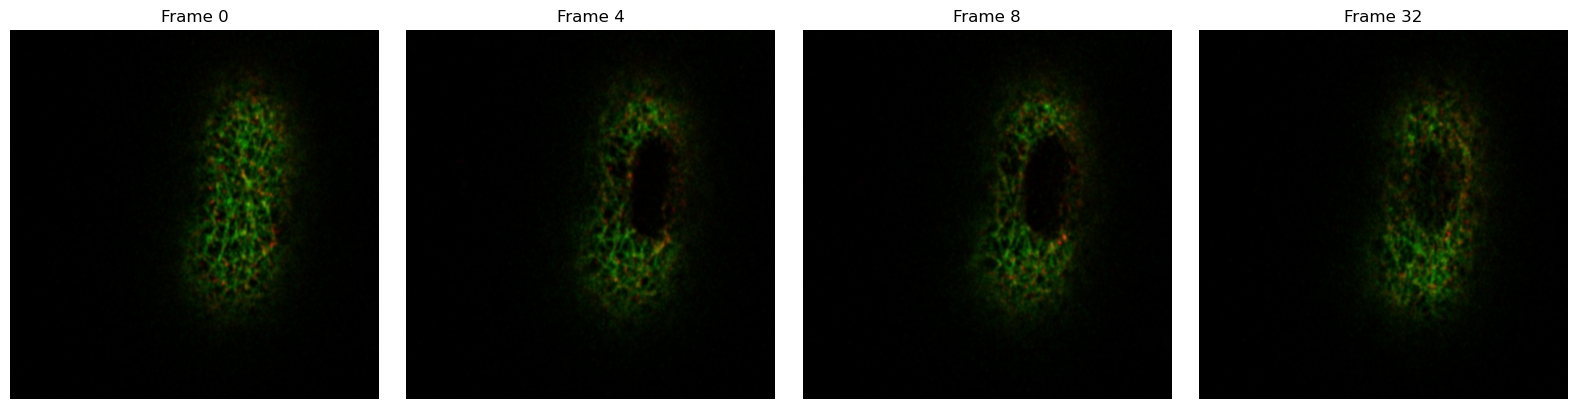

In [5]:
def visualize_frames_grid(rgb_stack: np.ndarray, frames: list[int]):
    n_frames = len(frames)
    cols = 4
    rows = (n_frames + cols - 1) // cols  # ceiling division

    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
    axes = np.array(axes).reshape(rows, cols)

    for i, frame_idx in enumerate(frames):
        r, c = divmod(i, cols)

        img = np.zeros((*rgb_stack.shape[1:3], 3))
        img[..., 0] = rgb_stack[frame_idx, :, :, 0]  # Red
        img[..., 1] = rgb_stack[frame_idx, :, :, 1]  # Green
        axes[r, c].imshow(np.clip(img, 0, 1))
        axes[r, c].set_title(f"Frame {frame_idx}")
        axes[r, c].axis('off')

    # Hide any unused subplots
    for j in range(i + 1, rows * cols):
        r, c = divmod(j, cols)
        axes[r, c].axis('off')

    plt.tight_layout()
    plt.show()

visualize_frames_grid(rgb_stack, [0, 4, 8, 32])

## Pipeline

We try the following pipeline:

1) Detect and localize particles (LoG + subpixel Gaussian fit) $\implies$ get $(x_i^t, y_i^t)$ and $(x_i^{t+1}, y_i^{t+1})$
2) Link robustly with a motion prior (e.g. Hungarian, gating, Kalman, ...)


### Laplacian Of Gaussians

In [6]:
def laplacian_of_gaussians(rgb_stack, frame, channel=0, min_sig=1, max_sig=10, num_sig=10, threshold = 0.02):
    blobs_log = feature.blob_log(
        rgb_stack[frame, :, :, channel],
        min_sigma=min_sig,
        max_sigma=max_sig,
        num_sigma=num_sig,
        threshold=threshold
    )

    fig, ax = plt.subplots()
    ax.imshow(rgb_stack[frame, :, :, channel], cmap='gray')
    for y, x, r in blobs_log:
        c = plt.Circle((x, y), r, color='red', linewidth=1.5, fill=False)
        ax.add_patch(c)
    plt.show()

    return blobs_log

In [7]:
def refine_subpixel_gaussian(rgb_stack, frame, channel=0, blobs=[], halfw=5):
    """
    Fit a 2D Gaussian around each blob for subpixel refinement.
    Returns Nx2 array of refined (y, x) coordinates.
    """
    refined = []
    im = rgb_stack[frame, :, :, channel]
    ny, nx = im.shape

    for y0, x0, s in blobs:
        y0, x0 = int(y0), int(x0)
        if (y0 < halfw or x0 < halfw or
            y0 >= ny - halfw or x0 >= nx - halfw):
            continue

        patch = im[y0-halfw:y0+halfw+1, x0-halfw:x0+halfw+1]
        yy, xx = np.mgrid[-halfw:halfw+1, -halfw:halfw+1]

        def gauss2d(params):
            A, x_c, y_c, sx, sy, offset = params
            g = A * np.exp(-(((xx - x_c)**2)/(2*sx**2) +
                             ((yy - y_c)**2)/(2*sy**2))) + offset
            return (g - patch).ravel()

        # initial guess
        p0 = [patch.max() - patch.min(), 0, 0, s, s, patch.min()]
        try:
            res = least_squares(gauss2d, p0, bounds=(
                [0, -2, -2, 0.5, 0.5, 0],
                [np.inf, 2, 2, 10, 10, np.inf]
            ))
            _, x_c, y_c, _, _, _ = res.x
            refined.append((y0 + y_c, x0 + x_c))
        except Exception:
            refined.append((y0, x0))

    refined = np.array(refined)
    fig, ax = plt.subplots()
    ax.imshow(rgb_stack[frame, :, :, channel], cmap='gray')
    ax.scatter(refined[:, 1], refined[:, 0], color='red', s=1)
    
    plt.show()

    return refined

In [8]:
def link_frames(pos0, pos1, max_disp=10):
    D = cdist(pos0, pos1)
    i0, i1 = linear_sum_assignment(D)
    valid = D[i0, i1] < max_disp
    return i0[valid], i1[valid], D[i0[valid], i1[valid]]

In [9]:
def compute_displacements(pos0, pos1, i0, i1):
    X = pos0[i0][:, ::-1]  # (x,y)
    dX = pos1[i1][:, ::-1] - pos0[i0][:, ::-1]
    return X, dX

In [10]:
def fit_gp_on_displacements(X, dX, length_scale=20.0, noise=0.1):
    kernel = 1.0 * RBF(length_scale=length_scale) + WhiteKernel(noise)
    gp_x = GaussianProcessRegressor(kernel=kernel, normalize_y=True)
    gp_y = GaussianProcessRegressor(kernel=kernel, normalize_y=True)
    gp_x.fit(X, dX[:, 0])
    gp_y.fit(X, dX[:, 1])
    return gp_x, gp_y

In [11]:
def predict_velocity_at_point(gp_x, gp_y, point):
    pt = np.array(point).reshape(1, -1)
    vx, sx = gp_x.predict(pt, return_std=True)
    vy, sy = gp_y.predict(pt, return_std=True)
    std_combined = np.hypot(sx, sy)
    return vx[0], vy[0], std_combined[0]

In [21]:
frame = 4
offset = 5

def analyze(rgb_stack, frame, offset, channel):
    im0 = rgb_stack[frame, :, :, channel]
    im1 = rgb_stack[frame + offset, :, :, channel]

    # 1) LoG detection
    blobs_a = laplacian_of_gaussians(rgb_stack, frame, channel, 1, 10, 10, 0.02)
    blobs_b = laplacian_of_gaussians(rgb_stack, frame + offset, channel, 1, 10, 10, 0.02)

    # 2) Subpixel refinement
    positions_a = refine_subpixel_gaussian(rgb_stack, frame, channel, blobs_a)
    positions_b = refine_subpixel_gaussian(rgb_stack, frame + offset, channel, blobs_b)

    # 3) Linking
    i0, i1, D = link_frames(positions_a, positions_b, max_disp=25)
    X, dX = compute_displacements(positions_a, positions_b, i0, i1)

    # 4) Fit GP field
    gp_x, gp_y = fit_gp_on_displacements(X, dX, length_scale=100, noise=0.3)

    # 5) Visualization
    def visualize_displacements(im0, im1, pos0, pos1, X, dX):
        """
        Visualize displacement vectors from pos0 to pos1, with positions overlaid.
        """
        fig, axes = plt.subplots(1, 2, figsize=(16, 8))

        for ax, im, title in zip(axes, [im0, im1], ['Frame 0', 'Frame 1']):
            ax.imshow(im, cmap='gray')
            
            # Plot original positions in red (pos0) and matched positions in green (pos1)
            ax.scatter(pos0[:, 1], pos0[:, 0], c='red', s=2, label='Positions in A')
            ax.scatter(pos1[:, 1], pos1[:, 0], c='green', s=2, label='Positions in B')
            
            # Draw arrows from pos0 to pos1
            # quiver uses (x, y) coordinates, so we swap columns for plotting
            plt.quiver(X[:, 0], X[:, 1], dX[:, 0], dX[:, 1], color='yellow', angles='xy', scale_units='xy', scale=1, width=0.002)

            ax.set_title(title)
            ax.invert_yaxis()  # Match image coordinate system
            ax.legend()

        plt.tight_layout()
        plt.show()

    visualize_displacements(im0, im1, positions_a, positions_b, X, dX)

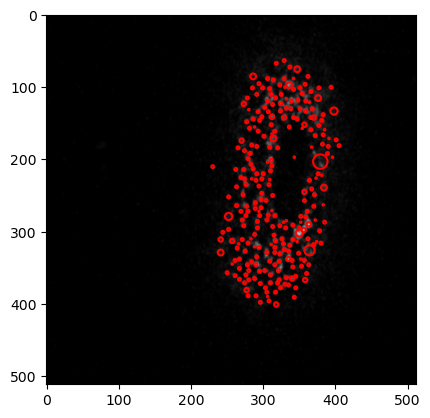

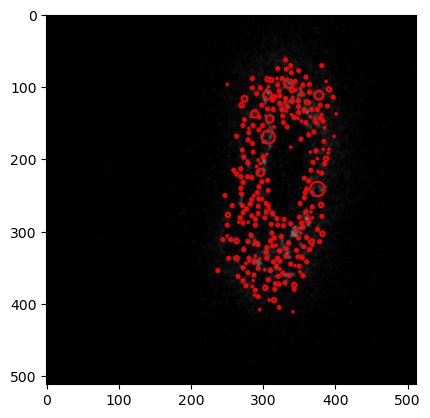

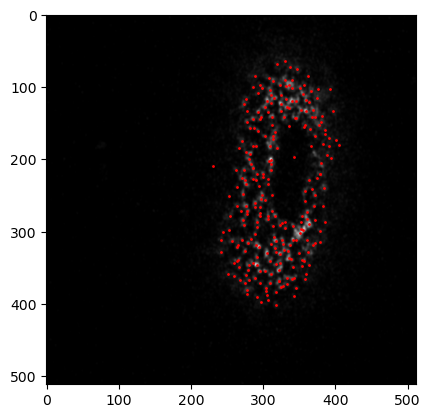

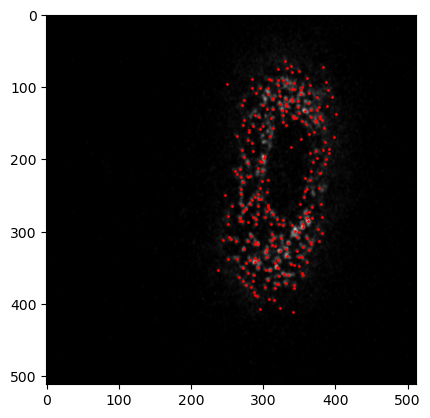

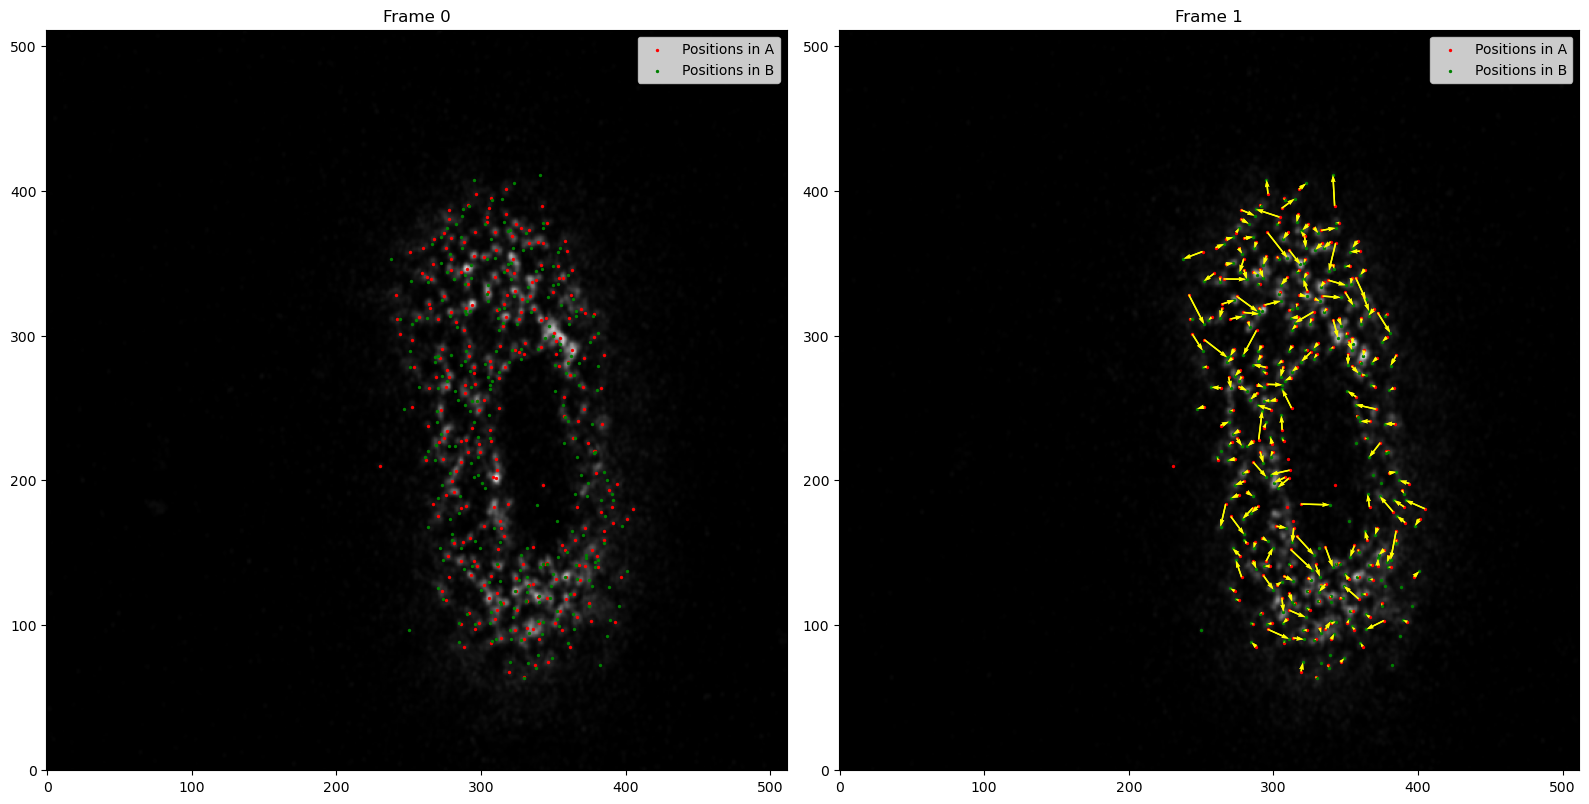

In [22]:
analyze(rgb_stack, frame, offset, 0)

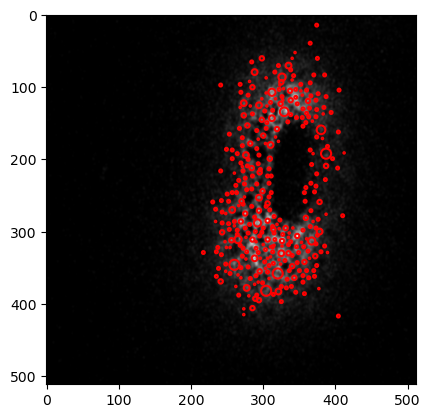

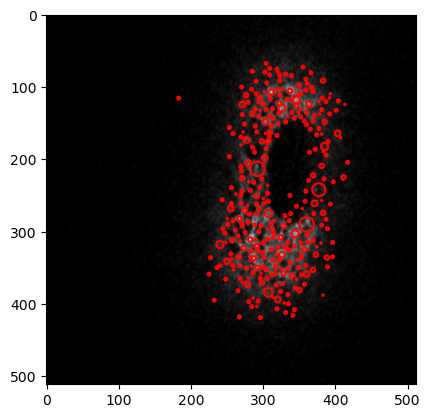

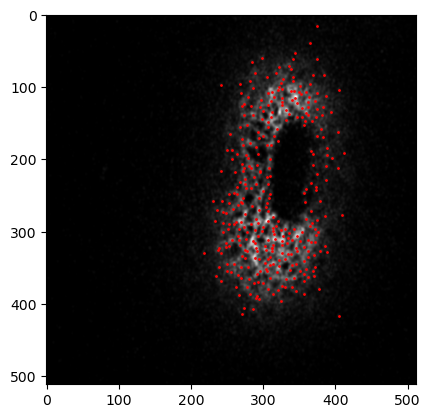

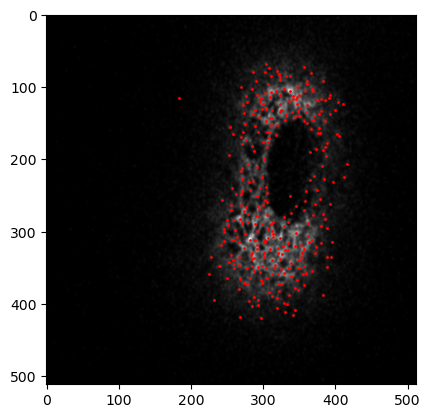

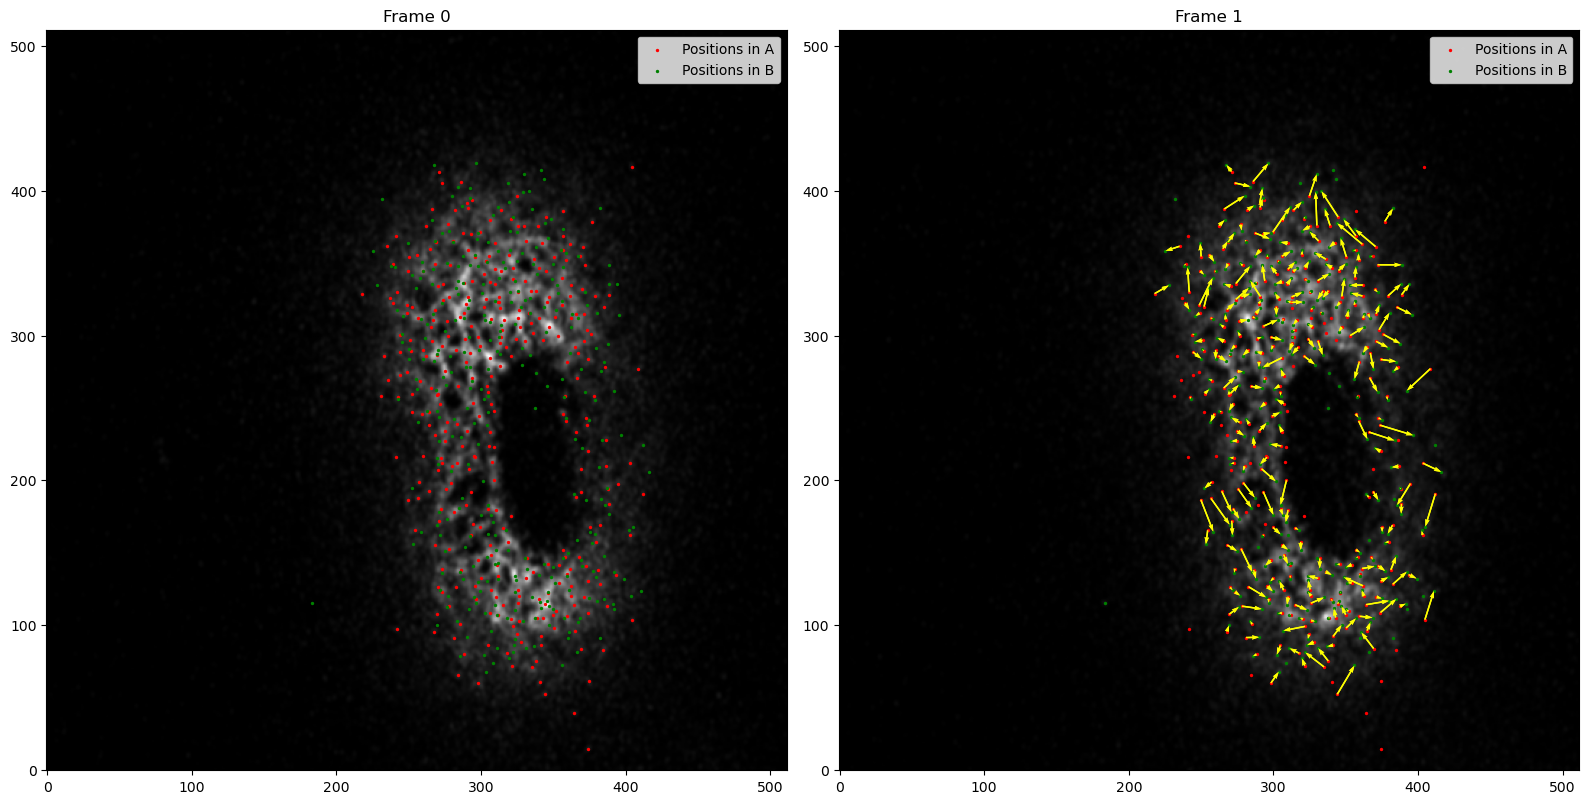

In [23]:
analyze(rgb_stack, frame, offset, 1)